In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import loadmat
from datetime import date

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# look at Horsager data
data_horsager = loadmat('../../data/Horsager_2011/S05_C3_C2.mat')
for x, y in zip(data_horsager['x'], data_horsager['y']):
    plt.plot(x, y, 'o')

In [ ]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(ampl, delay_dur=0, tsample=1e-5):
    freq = 50
    pulse_dur = 0.45/1000
    stim_dur = 0.5

    # envelope size (single pulse + gap) given by `freq`
    envelope_size = int(np.round((1/freq) / tsample))

    # delay given by `delay_dur`
    delay_size = int(np.round(delay_dur / tsample))
    delay = np.zeros(delay_size)

    # single pulse given by `pulse_dur`
    pulse = ampl * e2cm.get_pulse(pulse_dur, tsample, pulse_dur, 'cathodicfirst')
    pulse_size = pulse.size

    # then gap is used to fill up what's left
    gap_size = envelope_size - delay_size - pulse_size
    gap = np.zeros(gap_size)

    pulse_train = []
    for j in range(int(np.round(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, delay, pulse, gap), axis=0)
    
    return TimeSeries(tsample, pulse_train)

In [ ]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

In [ ]:
def run_condition(idx_cond, idx_E1, amp_E1, idx_E2, amp_E2, tm, cs, r, tsample):
    """Run a condition of the Horsager experiment
    
    Apply a list of currents `amp_E1` to electrode E1 and a list of currents `amp_E2` to E2.
    """
    amp_E1 = np.array(amp_E1)
    amp_E2 = np.array(amp_E2)
    
    # in order for zip to work, both amp arrays must have the same length
    if amp_E1.size == 1 and amp_E2.size > 1:
        amp_E1 = amp_E1.repeat(amp_E2.size)
    elif amp_E2.size == 1 and amp_E1.size > 1:
        amp_E2 = amp_E2.repeat(amp_E1.size)
    
    save_frames = []
    save_amp_E1 = []
    save_amp_E2 = []
    save_delay = []
    print ("Condition %d, E1=%d E2=%d" % (idx_cond, idx_E1, idx_E2))
    for delay in [0, 0.375/1000, 1.9/1000, 9/1000]:
        print("- delay %.3f" % (delay*1000))
        
        for a1, a2 in zip(amp_E1, amp_E2):
            print("  - amp_E1=%.2f amp_E2=%.2f" % (a1, a2))

            # generate list of pulse trains
            pt_list = []
            for j in range(16):
                if j == idx_E1:
                    pt_list.append(get_pulse_train(a1, tsample=tsample))
                elif j == idx_E2:
                    pt_list.append(get_pulse_train(a2, delay_dur=delay, tsample=tsample))
                else:
                    pt_list.append(get_pulse_train(0, tsample=tsample))
            
            # calculate response
            resp = ec2b.pulse2percept(tm, cs, r, pt_list, 30, dojit=True, n_jobs=4)
                        
            # save data
            save_frames.append(resp)
            save_amp_E1.append(a1)
            save_amp_E2.append(a2)
            save_delay.append(delay)
    
    filename = 'new_E' + str(idx_E1) + '_E' + str(idx_E2) + '_cond' + str(idx_cond) + \
        '_' + date.today().strftime("%Y-%m-%d") + '-X.npz'
    np.savez(filename, frames=save_frames, cond=idx_cond, E1=idx_E1, E2=idx_E2, 
             amp_E1=save_amp_E1, amp_E2=save_amp_E2, delay=save_delay)
    print('Results saved to %s' % filename)

In [48]:
# sampling step in seconds
tsample = 5e-6

# threshold current in micro amps
amp_thresh = 30

# current of reference electrode, at some factor x threshold
amp_ref = 1.5 * amp_thresh

# standard temporal model
tm = ec2b.TemporalModel(model='Nanduri', tsample=tsample)

In [49]:
# Create a Retina object that can hold the entire Argus I array (4x4 checkerboard, 880um center-to-center)
# width: 4 x 880um = 3520um, but add radii: 3520um + 130um + 260um = 3910 um, but add padding for current spread -> 5000um
r_sampling = 250  # spatial sampling of retina
r = e2cm.Retina(axon_map='../retina_argus_s' + str(r_sampling) + '.npz', 
                sampling=r_sampling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [ ]:
# Create Argus I electrode array 
# 4x4 checkerboard, 880um center-to-center, (almost) alternating electrode sizes

e_spacing = 880  # um
x_coord = np.arange(0, 4) * e_spacing - 1.5 * e_spacing
x_coord, y_coord = np.meshgrid(x_coord, x_coord, sparse=False)

# spatial arrangement of Argus I creates checkerboard with alternating electrode sizes
#   .  o  .  o
#   o  .  o  .
#   .  o  .  o
#   o  .  o  .
r_arr = np.array([260, 520, 260, 520])
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*100

e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_coord.flatten().tolist(),
                            y_coord.flatten().tolist(), h_arr.tolist())

In [ ]:
# show the cumulative current spread of the Argus I electrode arrangement
plt.matshow(np.flipud(e_all.current_spread(r.gridx, r.gridy)),
            vmin=0, cmap='hot')

# also plot the center points of all the electrodes
plt.plot(x_coord/r_sampling+r.gridx.shape[0]/2,
         y_coord/r_sampling+r.gridx.shape[0]/2, '.')

plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()

In [ ]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs = r.electrode_ecs(e_all)

In [ ]:
# C1 / D1 electrode index
idx_E1 = 2
idx_E2 = 3

for idx_cond in range(5):
    run_condition(idx_cond + 1, idx_E1, amp_E1[idx_cond], 
                  idx_E2, amp_E2[idx_cond], 
                  tm, cs, r, tsample)

In [ ]:
# C3 / C2 electrode index
idx_E1 = 10
idx_E2 = 6

for idx_cond in range(5):
    run_condition(idx_cond + 1, idx_E1, amp_E1[idx_cond], 
                  idx_E2, amp_E2[idx_cond], 
                  tm, cs, r, tsample)

In [ ]:
# C3 / B2 electrode index
idx_E1 = 10
idx_E2 = 5

for idx_cond in range(5):
    run_condition(idx_cond + 1, idx_E1, amp_E1[idx_cond], 
                  idx_E2, amp_E2[idx_cond], 
                  tm, cs, r, tsample)

In [ ]:
# A1 / A2 electrode index
idx_E1 = 0
idx_E2 = 4

for idx_cond in range(5):
    run_condition(idx_cond + 1, idx_E1, amp_E1[idx_cond], 
                  idx_E2, amp_E2[idx_cond], 
                  tm, cs, r, tsample)

In [ ]:
# B2 / B4 electrode index
idx_E1 = 5
idx_E2 = 13

for idx_cond in range(5):
    run_condition(idx_cond + 1, idx_E1, amp_E1[idx_cond], 
                  idx_E2, amp_E2[idx_cond], 
                  tm, cs, r, tsample)

In [ ]:
# C4 / C1 electrode index
idx_E1 = 14
idx_E2 = 2


for idx_cond in range(5):
    run_condition(idx_cond + 1, idx_E1, amp_E1[idx_cond], 
                  idx_E2, amp_E2[idx_cond], 
                  tm, cs, r, tsample)

In [4]:
def fit_amps(x, y, match_y):
    # spline interpolation for given x,y measurements
    f = interp1d(x, y, fill_value='extrapolate')
    
    # finer-grained x-scale
    x_finer = np.linspace(x[0], x[-1], 1000)
    
    # find idx of argmin
    idx = np.abs(f(x_finer) - match_y).argmin()
    
    # return x value
    return x_finer[idx]

In [5]:
def fit_gamma(x, y):
    # for all points (x,y), calculate r and compare to predicted
    best_err = np.inf
    best_gamma = 0
    for gamma in np.linspace(-1, 2, 100):
        err = np.sum(np.abs( np.sqrt(x**2 + y**2 + gamma * x * y) - 1))
        if err < best_err:
            best_err = err
            best_gamma = gamma
    return best_gamma

In [6]:
def movie2bright(pt, mode='softmax'):
    if mode == 'max':
        return pt.max()
    elif mode == 'softmax':
        # frame-wise softmax
        return (np.exp(pt) / np.exp(pt).sum(axis=(0,1))).max(axis=(0,1)).max()
    elif mode == 'mean':
        return pt.mean(axis=(0,1)).max()
    else:
        raise ValueError('Unknown mode "' + mode + '"')

In [39]:
def get_isobrightness(idx_E1, idx_E2, prefix, suffix, mode='max'):
    el_str = prefix + 'E' + str(idx_E1) + '_E' + str(idx_E2)
    print("  " + el_str)
    data_cond1 = np.load(el_str + '_cond1_' + suffix + '.npz')
    data_cond2 = np.load(el_str + '_cond2_' + suffix + '.npz')
    data_cond3 = np.load(el_str + '_cond3_' + suffix + '.npz')
    data_cond4 = np.load(el_str + '_cond4_' + suffix + '.npz')
    data_cond5 = np.load(el_str + '_cond5_' + suffix + '.npz')

    delay = [0.075, 0.375, 1.8, 9]

    # reference brightness from single electrode
    match_b1 = movie2bright(data_cond1['frames'][2].data, mode)
    match_b2 = movie2bright(data_cond2['frames'][2].data, mode)

    gamma = []
    amp1 = []
    amp2 = []
    for j in range(len(delay)):
        plot_amp1 = [0]
        plot_amp2 = [1]

        # condition 3
        x3 = data_cond3['amp_E2'][0:len(amp_E2[2])]
        y3 = [movie2bright(f.data, mode) for f in data_cond3['frames'][j*len(amp_E2[2]):(j+1)*len(amp_E2[2])]]
        amp_b3 = fit_amps(x3, y3, match_b2)
        plot_amp1.append(data_cond3['amp_E1'][2] / amp_ref)
        plot_amp2.append(amp_b3 / amp_ref)

        # condition 5
        x5 = data_cond5['amp_E1'][0:len(amp_E1[4])]
        y5 = [movie2bright(f.data, mode) for f in data_cond5['frames'][j*len(amp_E1[4]):(j+1)*len(amp_E1[4])]]
        amp_b5 = fit_amps(x5, y5, match_b1)
        plot_amp1.append(amp_b5 / amp_ref)
        x5 = data_cond5['amp_E2'][0:len(amp_E2[4])]
        y5 = [movie2bright(f.data, mode) for f in data_cond5['frames'][j*len(amp_E2[4]):(j+1)*len(amp_E2[4])]]
        amp_b5 = fit_amps(x5, y5, match_b2)
        plot_amp2.append(amp_b5 / amp_ref)

        # condition 4
        x4 = data_cond4['amp_E1'][0:len(amp_E1[3])]
        y4 = [movie2bright(f.data, mode) for f in data_cond4['frames'][j*len(amp_E1[3]):(j+1)*len(amp_E1[3])]]
        amp_b4 = fit_amps(x4, y4, match_b1)
        plot_amp1.append(amp_b4 / amp_ref)
        plot_amp2.append(data_cond4['amp_E2'][3] / amp_ref)

        plot_amp1.append(1)
        plot_amp2.append(0)
        
        gamma.append(fit_gamma(np.array(plot_amp1), np.array(plot_amp2)))        
        amp1.append(plot_amp1)
        amp2.append(plot_amp2)
        
    return (amp1, amp2, gamma)

In [40]:
# how to get brightness from pulse train
# {'max', 'softmax', 'mean'}
mode = 'softmax'

prefix = 'new_'
suffix = '2016-10-01-X'
idx_E1 = [2, 10, 10, 0,  5, 14]
idx_E2 = [3,  6,  5, 4, 13,  2]
idx_title = ['C1, D1', 'C3, C2', 'C3, B2', 'A1, A2', 'B2, B4', 'C4, C2']
delay = [0.075, 0.375, 1.8, 9]

print(prefix + suffix + ": " + mode)
all_amp1 = []
all_amp2 = []
all_gamma = []
for E1, E2, title in zip(idx_E1, idx_E2, idx_title):
    print('- Processing E%d, E%d: %s' % (E1, E2, title))
    amp1, amp2, gamma = get_isobrightness(E1, E2, prefix, suffix, mode=mode)
    all_amp1.append(amp1)
    all_amp2.append(amp2)
    all_gamma.append(gamma)

all_gamma = np.array(all_gamma)

new_2016-10-01-X: softmax
- Processing E2, E3: C1, D1
  new_E2_E3
- Processing E10, E6: C3, C2
  new_E10_E6
- Processing E10, E5: C3, B2
  new_E10_E5
- Processing E0, E4: A1, A2
  new_E0_E4
- Processing E5, E13: B2, B4
  new_E5_E13
- Processing E14, E2: C4, C2
  new_E14_E2


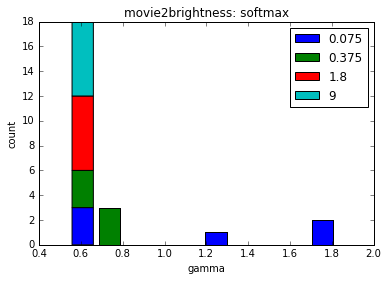

In [29]:
plt.hist(all_gamma, stacked=True, label=delay)
plt.xlabel('gamma')
plt.ylabel('count')
plt.legend()
plt.title('movie2brightness: ' + mode)
plt.savefig('data/plot_gamma_' + mode + '.jpg')

In [36]:
index = 0
plt.plot(np.array(all_amp1[index]).T, np.array(all_amp2[index]).T, 'o-', label=delay, linewidth=2)
plt.plot([1, 0], [0, 1], '--')
plt.xlabel('E1')
plt.ylabel('E2')
plt.legend(loc='upper right')
plt.title(idx_title[index])
plt.axis('equal')
plt.legend(delay)

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.2, 0.25, 0.25]
ax2 = plt.axes([left, bottom, width, height])
ax2.plot(all_gamma[index], 'o-k')
ax2.plot([0, len(delay) - 1], [0, 0], ':k')
ax2.plot([0, len(delay) - 1], [1, 1], ':k')
plt.xticks(range(len(delay)), delay)
plt.yticks([-1, 0, 1, 2])
plt.ylim(-1, 2)
plt.savefig('data/plot_' + prefix + idx_title[index].replace(", ", "-") + "_" + mode + "_" + suffix + '.jpg')

IndexError: list index out of range